In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.16.1


### Fetch target stock price history data

In [3]:
# 抓取台積電的歷史股價資料
stock = '2330.TW'
stock_data = yf.download(stock, start='2010-01-01', end='2023-12-31')
stock_data = stock_data.reset_index()
stock_data = stock_data[['Date', 'High', 'Low', 'Open', 'Close']]
stock_data.columns = ['date', 'high', 'low', 'open', 'close']
stock_data['ticker'] = stock  # 添加一列來標識股票
print(stock_data.head())

[*********************100%%**********************]  1 of 1 completed

        date       high        low       open      close   ticker
0 2010-01-04  65.000000  64.000000  65.000000  64.900002  2330.TW
1 2010-01-05  65.099998  63.900002  65.000000  64.500000  2330.TW
2 2010-01-06  64.900002  63.700001  64.500000  64.900002  2330.TW
3 2010-01-07  65.000000  64.199997  64.900002  64.199997  2330.TW
4 2010-01-08  64.300003  63.500000  63.500000  64.000000  2330.TW


### Data preprocessing
split the dataset into training set(for fine-tuned) and testing set by the ratio 8:2

In [5]:
# 標準化數據
scaler = MinMaxScaler(feature_range=(0, 1))
data = stock_data[['open', 'high', 'low', 'close']].values
data_scaled = scaler.fit_transform(data)

# 創建數據集
def create_single_stock_dataset(data_scaled, time_step=30):
    dataX, dataY = [], []
    for i in range(len(data_scaled) - time_step - 1):
        a = data_scaled[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(data_scaled[i + time_step, -1])  # 使用'close'作為目標變量
    return np.array(dataX), np.array(dataY)

# 參數
time_step = 30
x_stock, y_stock = create_single_stock_dataset(data_scaled, time_step)

# 調整輸入形狀以符合模型需求
x_stock = x_stock.reshape(x_stock.shape[0], x_stock.shape[1], x_stock.shape[2])

# 劃分訓練集和測試集
train_size = int(len(x_stock) * 0.8)
x_stock_train, x_stock_test = x_stock[:train_size], x_stock[train_size:]
y_stock_train, y_stock_test = y_stock[:train_size], y_stock[train_size:]

print('x_stock_train shape: {}'.format(x_stock_train.shape))
print('y_stock_train shape: {}'.format(y_stock_train.shape))
print('x_stock_test shape: {}'.format(x_stock_test.shape))
print('y_stock_test shape: {}'.format(y_stock_test.shape))

x_stock_train shape: (2718, 30, 4)
y_stock_train shape: (2718,)
x_stock_test shape: (680, 30, 4)
y_stock_test shape: (680,)


### Load pre-trained model

In [8]:
pretrained_model = load_model('10_stocks_pretrained_model.keras')


c:\Users\ASUS\.virtualenvs\1122DL_Final-Project-sJrsncux\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Model's performance before fine-tuned

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fine-tuned RMSE: 41.357371371007524


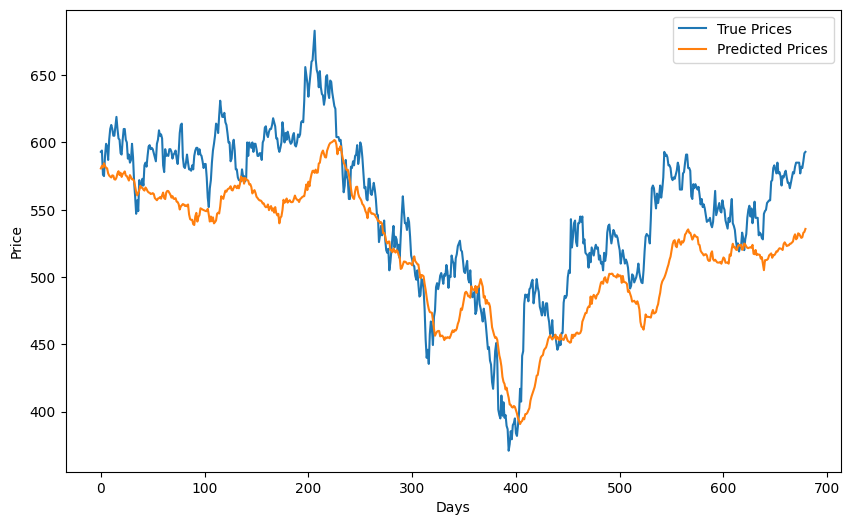

In [9]:
# 微調前的模型預測表現
predicted_stock_prices = pretrained_model.predict(x_stock_test)

# 反標準化預測值
def inverse_transform(scaler, data, original_shape):
    result = []
    for i in range(len(data)):
        scaled_data = np.concatenate([np.zeros((1, original_shape - 1)), data[i].reshape(1, -1)], axis=1)
        result.append(scaler.inverse_transform(scaled_data)[0, -1])
    return np.array(result)

predicted_stock_prices = inverse_transform(scaler, predicted_stock_prices, original_shape=x_stock.shape[2])
y_stock_test_true = inverse_transform(scaler, y_stock_test.reshape(-1, 1), original_shape=x_stock.shape[2])

# 計算微調後的RMSE
fine_tune_rmse = math.sqrt(mean_squared_error(y_stock_test_true, predicted_stock_prices))

print(f"Fine-tuned RMSE: {fine_tune_rmse}")

# 畫出預測結果
plt.figure(figsize=(10, 6))
plt.plot(y_stock_test_true, label='True Prices')
plt.plot(predicted_stock_prices, label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


### Fine-tuned stage

In [11]:
fine_tune_model = load_model('10_stocks_pretrained_model.keras')

# 微調模型
fine_tune_model.compile(optimizer='adam', loss='mean_squared_error')

# 使用台積電的訓練數據進行微調
fine_tune_history = fine_tune_model.fit(x_stock_train, y_stock_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20


c:\Users\ASUS\.virtualenvs\1122DL_Final-Project-sJrsncux\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.3484e-04 - val_loss: 0.0048
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1577e-04 - val_loss: 0.0064
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6005e-04 - val_loss: 0.0068
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6972e-04 - val_loss: 0.0075
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2561e-04 - val_loss: 0.0076
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.3777e-04 - val_loss: 0.0081
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1380e-04 - val_loss: 0.0079
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1568e-04 - val_loss: 0.0089
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3934e-04 - val_loss: 0.0085
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.8630e-05 - val_loss: 0.0091
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2166e-04 - val_loss: 0.0076
Epoch 12/20
68/68 ━━━━━━━━━━━━

### Model's performance after fine-tuned

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fine-tuned RMSE: 79.57671156899121


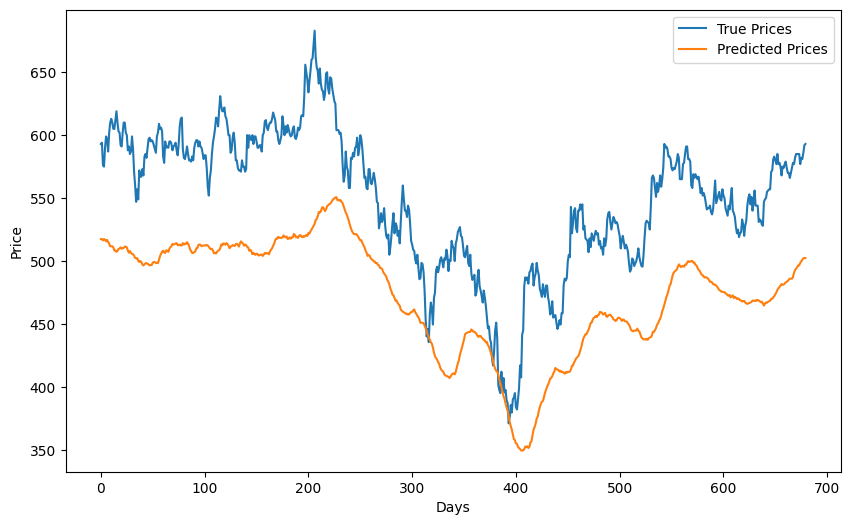

In [12]:
# 使用微調後的模型進行預測
predicted_stock_prices = fine_tune_model.predict(x_stock_test)

# 反標準化預測值
def inverse_transform(scaler, data, original_shape):
    result = []
    for i in range(len(data)):
        scaled_data = np.concatenate([np.zeros((1, original_shape - 1)), data[i].reshape(1, -1)], axis=1)
        result.append(scaler.inverse_transform(scaled_data)[0, -1])
    return np.array(result)

predicted_stock_prices = inverse_transform(scaler, predicted_stock_prices, original_shape=x_stock.shape[2])
y_stock_test_true = inverse_transform(scaler, y_stock_test.reshape(-1, 1), original_shape=x_stock.shape[2])

# 計算微調後的RMSE
fine_tune_rmse = math.sqrt(mean_squared_error(y_stock_test_true, predicted_stock_prices))

print(f"Fine-tuned RMSE: {fine_tune_rmse}")

# 畫出預測結果
plt.figure(figsize=(10, 6))
plt.plot(y_stock_test_true, label='True Prices')
plt.plot(predicted_stock_prices, label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
